# House Prices: Advanced Regression Techniques (Kaggle)

Sources:
* Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
* Check missing values: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction by Will Koehrsen
* Neural net implementation: https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/ by Yashu Seth

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [2]:
# Show more rows and columns in the pandas output
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Helpers

In [4]:
def show_missing(df, show_all=True):
    """    
    Shows absolute and relative number of missing values for each column of a dataframe,
    show_all=True also shows columns with no missing values.
    """
    mis_val_abs = df.isnull().sum()
    mis_val_rel = df.isnull().sum()/df.shape[0]
    mis_val_table = pd.concat([df.dtypes, mis_val_abs, mis_val_rel], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'dtype', 1: 'Missing abs', 2: 'Missing rel'})

    if show_all:
        # Sort table descending by relative amount missing
        mis_val_table = mis_val_table.sort_values('Missing rel', ascending=False).round(3)
    else:
        # Sort table descending by relative amount missing, remove columns where no values are missing
        mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values('Missing rel', ascending=False).round(3)
    
    return mis_val_table

In [5]:
def impute_cont(df_train, df_test=None, cont_names=None, method='median'):
    '''
    Check each column of a dataframe for missing values (None, NaN),
    impute missing values with median or mean,
    create one-hot encoded vector for each column with missing values - marking the missing values
    return original dataframe and one-hot vectors combinded into a single dataframe.
    '''
    df_source = df_train.copy()
    df_target = df_test.copy()
    df_source_mis_onehot = pd.DataFrame()
    df_target_mis_onehot = pd.DataFrame()
    missing_cols = {}
    
    # If no cont names are specified, use all columns
    if not cont_names:
        cont_names = list(df_source.columns.values)
    
    mean = [df_train[name].mean() for name in cont_names]
    median = [df_train[name].median() for name in cont_names]
    mean_dict = dict(zip(cont_names, mean))
    median_dict = dict(zip(cont_names, median))
    
    # Traverse each column to check for missing values (NaN, None)
    for name in cont_names:
        source_missing = pd.isna(df_source[name])*1
        target_missing = pd.isna(df_target[name])*1
        if source_missing.sum() > 0 or target_missing.sum() > 0:
            # Impute missing values in df_source and df_target with mean/median of df_source
            if method == 'mean':
                df_source[name] = df_source[name].fillna(df_source[name].mean())
                df_target[name] = df_target[name].fillna(df_source[name].mean())
            else:
                df_source[name] = df_source[name].fillna(df_source[name].median())
                df_target[name] = df_target[name].fillna(df_source[name].median())
            
            # Get one-hot name
            missing_cols[name] = 'mis_'+name
            
            # Add one-hot vector to temporary dataframe
            df_source_mis_onehot = pd.concat([df_source_mis_onehot, source_missing], axis=1)
            df_target_mis_onehot = pd.concat([df_target_mis_onehot, target_missing], axis=1)
    
    # Rename new one-hot encoded columns
    df_source_mis_onehot = df_source_mis_onehot.rename(columns=missing_cols)
    df_target_mis_onehot = df_target_mis_onehot.rename(columns=missing_cols)
    
    # If there were missing values, combine one-hot df with imputed df
    if len(df_source_mis_onehot) > 0 or len(df_target_mis_onehot) > 0:
        df_source = pd.concat([df_source, df_source_mis_onehot], axis=1)
        df_target = pd.concat([df_target, df_target_mis_onehot], axis=1)        
    
    return df_source, df_target

In [6]:
def normalize_cont(df_source, df_target=None, cont_names=None):
    if not cont_names:
        cont_names = df.source.columns
    
    try:
        source_mean = df_source[cont_names].mean()
        source_std = df_source[cont_names].std()        
        trans_source = df_source.copy()
        trans_target = df_target.copy()
        
        trans_source[cont_names] = (trans_source[cont_names]-source_mean[cont_names])/source_std[cont_names]
        if df_target is not None:            
            trans_target[cont_names] = (trans_target[cont_names]-source_mean[cont_names])/source_std[cont_names]
        
        return trans_source, trans_target
        
    except KeyError as e:
        print(f'Error: column {e} not in df_source.')
    

In [7]:
def proc_cats(df_source, df_target, cat_names=None):
    '''
    All variables passed in names will be treated as categoricals,
    and converted to the 'category' dtype.
    None/NaN will be labeled 0.
    dep will remain unchanged if specified.
    '''
    le = preprocessing.LabelEncoder()
    
    if not cat_names:
        cat_names = list(df_source.columns.values)
    
    # Init NaN row vector to make sure NaN gets labeled as 0 during le.fit
    nan_vec = pd.DataFrame(np.empty((1, df_train.shape[1]))*np.nan, columns=df_train.columns)
    
    # Init empty df
    trans_source = df_source.copy()
    trans_target = df_target.copy()
    df_combined = pd.concat([nan_vec, trans_source, trans_target], axis=0, sort=False)
    
    try:
        for name in cat_names:
            le.fit(df_combined[name].astype('category').cat.codes)
            #le.fit(pd.concat([nan_vec, df_source, df_target], axis=0, sort=False)[name].astype('category').cat.codes)
            trans_source[name] = le.transform(df_source[name].astype('category').cat.codes)
            trans_target[name] = le.transform(df_target[name].astype('category').cat.codes)
    except KeyError as e:
        print(f'Error: column {e} not in df_source')

    return trans_source, trans_target

In [8]:
def get_embedding_sizes(df_source, df_target=None):
    zeros = pd.DataFrame(np.zeros((1, df_source.shape[1])), columns=df_source.columns)
    data = pd.concat([zeros, df_source, df_target], axis=0, sort=False)[cat_names]
    num_factors = [int(data[col].nunique()) for col in data.columns]
    return [(x, min((x+1)//2, 50)) for x in num_factors]

## Load data

In [11]:
PATH = Path('../data/houseprice/')
#!dir {PATH}
!ls {PATH}

data_description.txt  sample_submission.csv  train.csv
models		      test.csv		     train_tiny.csv


In [179]:
# Import data
df_train = pd.read_csv(PATH/'train.csv', sep=',', header=0)
df_train.drop('Id', axis=1, inplace=True)
df_test = pd.read_csv(PATH/'test.csv', sep=',', header=0)
df_test.drop('Id', axis=1, inplace=True)
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

TODO: pre-process 1
0. **get proper embedding sizes when combining train+valid+test(+nan_vec) so that we have ALL indices (also UNK) at the time the embeddings are created**
0. make function to process train+valid+test data at once
2. cont: make float32 or float16
7. cat: calc embedding sizes

DONE:
1. seperate continuous variables from categorical variables
3. cont: deal with missing values (mean, median)
4. cont: make 1-hot vector for replaced values
5. cat: convert to int (.code or something)
6. cat: deal with missing values
1. normalize train/val, apply to test
2. categorify train/val, apply to test



### test cat

In [ ]:
cat1 = pd.DataFrame(["a", "b", "a", "a", "c", "d", "a", "b"], columns=['cat1'])
cat2 = pd.DataFrame(["x", None, "x", "x", "y", "y", "y", None], columns=['cat2'])
cat3 = pd.DataFrame(["j", "i", "g", "g", "i", "h", "i", "j"], columns=['cat3'])
xcat = pd.concat([cat1, cat2, cat3], axis=1)
xcat

In [ ]:
cat1_3 = pd.DataFrame([None, "f", "e", "a", "c", "d", "a", "b"], columns=['cat1'])
cat2_3 = pd.DataFrame(["x", None, "x", "x", "y", "y", "y", None], columns=['cat2'])
cat3_3 = pd.DataFrame(["j", "i", "g", "g", "i", "h", "i", "j"], columns=['cat3'])
xcat4 = pd.concat([cat1_3, cat2_3, cat3_3], axis=1)
xcat4

In [ ]:
cat1_1 = pd.DataFrame(["b", "c", "a", "d", "b", "a", "c", "b"], columns=['cat1'], dtype='category')
cat2_1 = pd.DataFrame(["y", "x", "y", "x", "y", "y", "y", None], columns=['cat2'], dtype='category')
cat3_1 = pd.DataFrame(["g", "h", "j", "g", "i", "h", "i", "j"], columns=['cat3'], dtype='category')
xcat2 = pd.concat([cat1_1, cat2_1, cat3_1], axis=1)
xcat2

In [ ]:
cat1_2 = pd.DataFrame(["b", "c", "a", "d", "b", "a", "c", "b"], columns=['cat1'])
cat2_2 = pd.DataFrame(["y", "x", "y", "x", "y", "y", "y", None], columns=['cat2'])
cat3_2 = pd.DataFrame(["g", "h", "j", "g", "i", "h", "i", "j"], columns=['cat3'])
xcat3 = pd.concat([cat1_2, cat2_2, cat3_2], axis=1)
xcat3

In [ ]:
show_missing(xcat)

In [ ]:
t_xcat, t_xcat4 = proc_cats(xcat, xcat4, cat_names=['cat1', 'cat2', 'cat3'])

In [ ]:
t_xcat, t_xcat4 = proc_cats(xcat, xcat4, dep='cat1')

In [ ]:
pd.concat([xcat, t_xcat], axis=1)

In [ ]:
pd.concat([xcat4, t_xcat4], axis=1)

### test cont

In [ ]:
cont1 = pd.DataFrame([1, 2, 3, 4, 5, np.nan, 7, np.nan], dtype=float, columns=['cont1'])
cont2 = pd.DataFrame([np.nan, 2, 3, 4, 5, 6, 7, np.nan], dtype=float, columns=['cont2'])
cont3 = pd.DataFrame([None, 2, 3, 4, None, 6, 7, None], dtype=float, columns=['cont3'])
xcont = pd.concat([cont1, cont2, cont3], axis=1) #, ignore_index=True)

In [ ]:
cont1_1 = pd.DataFrame([0, 7, 8, 4, 5, np.nan, 7, np.nan], dtype=float, columns=['cont1'])
cont2_1 = pd.DataFrame([1, 4, 1, 2, 5, 6, 7, np.nan], dtype=float, columns=['cont2'])
cont3_1 = pd.DataFrame([None, 2, 3, 4, None, 6, 7, None], dtype=float, columns=['cont3'])
xcont2 = pd.concat([cont1_1, cont2_1, cont3_1], axis=1) #, ignore_index=True)

In [ ]:
show_missing(xcont)

In [ ]:
pd.concat([xcont, xcont2], axis=1)

In [ ]:
t_xcont, t_xcont2 = impute_cont(xcont, xcont2)

In [ ]:
pd.concat([t_xcont, t_xcont2], axis=1)

In [ ]:
show_missing(t_xcont)

In [ ]:
cont_names = ['cont1','cont2','cont3']

In [ ]:
t_xcont[cont_names] = (t_xcont[cont_names]-t_xcont[cont_names].mean())/t_xcont[cont_names].std()

In [ ]:
t_xcont[cont_names]

In [ ]:
print(t_xcont[cont_names].mean())
print(t_xcont[cont_names].std())
for name in cont_names:
    #print(t_xcont.mean())
    print((t_xcont[name]-t_xcont[name].mean())/t_xcont[name].std())
    

In [ ]:
mean1 = t_xcont[cont_names].mean()
mean1

In [ ]:
t_xcont[cont_names]-t_xcont[cont_names].mean()==t_xcont[cont_names]-mean1[cont_names]

In [ ]:
tn_xcont, tn_xcont2 = normalize_cont(t_xcont, t_xcont2, cont_names=cont_names)

In [ ]:
pd.concat([tn_xcont, tn_xcont2], axis=1)

## Pre-processing

In [13]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [180]:
dep = ['SalePrice']

In [181]:
cat_names = list(df_train.select_dtypes('object').columns)

In [182]:
cont_names = list(set(df_train.columns)-set(dep)-set(cat_names))

In [183]:
df_train[cat_names].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [184]:
df_train[cont_names].describe()

,TotRmsAbvGrd,LotFrontage,BsmtFinSF1,EnclosedPorch,GarageYrBlt,OpenPorchSF,YrSold,BsmtHalfBath,MasVnrArea,BsmtUnfSF,FullBath,ScreenPorch,MSSubClass,TotalBsmtSF,GrLivArea,MiscVal,KitchenAbvGr,GarageCars,WoodDeckSF,OverallCond,Fireplaces,LowQualFinSF,GarageArea,LotArea,OverallQual,3SsnPorch,BsmtFullBath,HalfBath,2ndFlrSF,BsmtFinSF2,PoolArea,BedroomAbvGr,YearBuilt,YearRemodAdd,1stFlrSF,MoSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.517808,70.049958,443.639726,21.954110,1978.506164,46.660274,2007.815753,0.057534,103.685262,567.240411,1.565068,15.060959,56.897260,1057.429452,1515.463699,43.489041,1.046575,1.767123,94.244521,5.575342,0.613014,5.844521,472.980137,10516.828082,6.099315,3.409589,0.425342,0.382877,346.992466,46.549315,2.758904,2.866438,1971.267808,1984.865753,1162.626712,6.321918
std,1.625393,24.284752,456.098091,61.119149,24.689725,66.256028,1.328095,0.238753,181.066207,441.866955,0.550916,55.757415,42.300571,438.705324,525.480383,496.123024,0.220338,0.747315,125.338794,1.112799,0.644666,48.623081,213.804841,9981.264932,1.382997,29.317331,0.518911,0.502885,436.528436,161.319273,40.177307,0.815778,30.202904,20.645407,386.587738,2.703626
min,2.000000,21.000000,0.000000,0.000000,1900.000000,0.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1872.000000,1950.000000,334.000000,1.000000
25%,5.000000,59.000000,0.000000,0.000000,1961.000000,0.000000,2007.000000,0.000000,0.000000,223.000000,1.000000,0.000000,20.000000,795.750000,1129.500000,0.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,334.500000,7553.500000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1954.000000,1967.000000,882.000000,5.000000
50%,6.000000,69.000000,383.500000,0.000000,1980.000000,25.000000,2008.000000,0.000000,0.000000,477.500000,2.000000,0.000000,50.000000,991.500000,1464.000000,0.000000,1.000000,2.000000,0.000000,5.000000,1.000000,0.000000,480.000000,9478.500000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1973.000000,1994.000000,1087.000000,6.000000
75%,7.000000,80.000000,712.250000,0.000000,2002.000000,68.000000,2009.000000,0.000000,166.000000,808.000000,2.000000,0.000000,70.000000,1298.250000,1776.750000,0.000000,1.000000,2.000000,168.000000,6.000000,1.000000,0.000000,576.000000,11601.500000,7.000000,0.000000,1.000000,1.000000,728.000000,0.000000,0.000000,3.000000,2000.000000,2004.000000,1391.250000,8.000000
max,14.000000,313.000000,5644.000000,552.000000,2010.000000,547.000000,2010.000000,2.000000,1600.000000,2336.000000,3.000000,480.000000,190.000000,6110.000000,5642.000000,15500.000000,3.000000,4.000000,857.000000,9.000000,3.000000,572.000000,1418.000000,215245.000000,10.000000,508.000000,3.000000,2.000000,2065.000000,1474.000000,738.000000,8.000000,2010.000000,2010.000000,4692.000000,12.000000


In [185]:
# Manually add additional names to the categorical variables that did not have the dtype object
cat_names.extend(['MoSold','TotRmsAbvGrd','KitchenAbvGr','BedroomAbvGr','GarageYrBlt',
                  'MSSubClass','YearRemodAdd','YearBuilt','BsmtFullBath','FullBath','HalfBath',
                  'OverallQual','YrSold','GarageCars','OverallCond','Fireplaces'])
cont_names = list(set(df_train.columns)-set(dep)-set(cat_names))

In [186]:
df_y = df_train.SalePrice
df_ptrain = df_train.copy()
df_ptrain.drop(dep, axis=1, inplace=True)

if df_y.dtype == 'object':
    df_y = df_y.astype('category').cat.codes

In [187]:
# Double check if assigning variables to cat_names and cont_names results in the same number of variables
len(df_ptrain.columns) == len(cat_names)+len(cont_names), len(cat_names)+len(cont_names)

(True, 79)

In [23]:
show_missing(df_train)

,dtype,Missing abs,Missing rel
PoolQC,object,1453,0.995
MiscFeature,object,1406,0.963
Alley,object,1369,0.938
Fence,object,1179,0.808
FireplaceQu,object,690,0.473
LotFrontage,float64,259,0.177
GarageType,object,81,0.055
GarageYrBlt,float64,81,0.055
GarageQual,object,81,0.055
GarageCond,object,81,0.055


In [188]:
df_ptrain, df_ptest = proc_cats(df_train, df_test, cat_names=cat_names)

In [189]:
df_ptrain[cat_names].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MoSold,TotRmsAbvGrd,KitchenAbvGr,BedroomAbvGr,GarageYrBlt,MSSubClass,YearRemodAdd,YearBuilt,BsmtFullBath,FullBath,HalfBath,OverallQual,YrSold,GarageCars,OverallCond,Fireplaces
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,4.028767,1.995890,0.090411,2.942466,3.777397,1.000685,4.019178,1.062329,13.251370,3.031507,3.008219,1.493151,4.038356,2.410274,2.075342,10.624658,11.339726,2.745890,3.539726,4.733562,2.396575,3.178767,3.715753,3.180137,3.637671,5.559589,2.036301,2.538356,1.934932,4.678767,3.339726,6.749315,1.969178,3.097260,2.062329,4.594521,4.628082,2.856164,0.010274,0.467123,0.107534,8.513014,4.770548,6.321918,5.517123,2.046575,3.865753,62.097945,5.166438,35.865753,73.975342,1.425342,2.565068,1.382877,6.099315,2.815753,2.767123,5.575342,1.613014
std,0.632017,0.063996,0.372151,1.409156,0.707666,0.026171,1.622634,0.276232,6.013735,0.868515,0.259040,1.198277,1.911305,0.834998,0.599127,3.197659,3.540570,0.646987,0.693995,0.731807,0.722394,0.998402,0.884346,1.246138,1.895727,1.296332,0.295124,1.739524,0.246731,1.058385,0.830161,0.979659,2.037956,1.890815,0.934939,1.262078,1.231595,0.496592,0.158916,1.029191,0.555437,1.552100,1.100854,2.703626,1.622446,0.220338,0.811875,27.910915,4.161951,20.645407,28.852359,0.518911,0.550916,0.502885,1.382997,1.328095,0.747315,1.112799,0.644666
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,0.000000,1.000000,4.000000,1.000000,3.000000,1.000000,8.000000,3.000000,3.000000,1.000000,3.000000,2.000000,2.000000,9.000000,9.000000,2.000000,3.000000,5.000000,2.000000,3.000000,4.000000,2.000000,2.000000,6.000000,2.000000,1.000000,2.000000,5.000000,3.000000,7.000000,0.000000,2.000000,1.000000,5.000000,5.000000,3.000000,0.000000,0.000000,0.000000,9.000000,5.000000,5.000000,4.000000,2.000000,3.000000,45.000000,1.000000,18.000000,56.000000,1.000000,2.000000,1.000000,5.000000,2.000000,2.000000,5.000000,1.000000
50%,4.000000,2.000000,0.000000,4.000000,4.000000,1.000000,5.000000,1.000000,13.000000,3.000000,3.000000,1.000000,3.000000,2.000000,2.000000,13.000000,14.000000,3.000000,4.000000,5.000000,2.000000,3.000000,4.000000,4.000000,3.000000,6.000000,2.000000,1.000000,2.000000,5.000000,4.000000,7.000000,2.000000,2.000000,2.000000,5.000000,5.000000,3.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000,5.000000,2.000000,4.000000,64.000000,5.000000,45.000000,75.000000,1.000000,3.000000,1.000000,6.000000,3

In [190]:
df_ptest[cat_names].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MoSold,TotRmsAbvGrd,KitchenAbvGr,BedroomAbvGr,GarageYrBlt,MSSubClass,YearRemodAdd,YearBuilt,BsmtFullBath,FullBath,HalfBath,OverallQual,YrSold,GarageCars,OverallCond,Fireplaces
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000
mean,4.015764,1.995888,0.098698,2.952707,3.776559,0.998629,4.092529,1.045236,13.623029,3.049349,2.995888,1.518163,3.638794,2.382454,1.015764,9.333790,10.708019,2.738862,3.521590,4.68403,2.389993,3.119945,3.67512,3.193968,3.677176,5.485949,1.013023,2.529130,1.930775,3.771761,3.351611,6.760795,1.845099,3.117204,2.069911,3.614805,4.636737,2.805346,0.002742,0.476354,0.099383,8.463331,4.787526,6.104181,4.384510,2.042495,3.854010,60.553119,5.296093,34.662783,68.130912,1.432488,2.570939,1.377656,6.078821,2.769705,2.764222,5.553804,1.58122
std,0.715610,0.064018,0.373861,1.410751,0.701340,0.037012,1.585797,0.217566,5.897889,0.879755,0.143385,1.214981,1.479778,0.806605,0.158520,2.438045,3.145055,0.662283,0.710527,0.81285,0.731936,1.050837,0.95438,1.234536,1.880327,1.411899,0.154388,1.746152,0.253924,0.771134,0.843202,0.923522,2.008725,1.894863,0.943125,1.097922,1.215884,0.574204,0.064091,1.022361,0.530671,1.649040,1.055436,2.722432,1.505201,0.208472,0.829788,28.127534,4.379313,21.130467,28.943443,0.532935,0.555190,0.503017,1.436812,1.301740,0.779052,1.113740,0.64742
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000
25%,4.000000,2.000000,0.000000,1.000000,4.000000,1.000000,3.000000,1.000000,9.000000,3.000000,3.000000,1.000000,3.000000,2.000000,1.000000,8.000000,9.000000,2.000000,3.000000,5.00000,2.000000,3.000000,4.00000,2.000000,2.000000,6.000000,1.000000,1.000000,2.000000,4.000000,3.000000,7.000000,0.000000,2.000000,1.000000,4.000000,5.000000,3.000000,0.000000,0.000000,0.000000,9.000000,5.000000,4.000000,3.000000,2.000000,3.000000,42.000000,1.000000,14.000000,49.000000,1.000000,2.000000,1.000000,5.000000,2.000000,2.000000,5.000000,1.00000
50%,4.000000,2.000000,0.000000,4.000000,4.000000,1.000000,5.000000,1.000000,13.000000,3.000000,3.000000,1.000000,3.000000,2.000000,1.000000,11.000000,13.000000,3.000000,4.000000,5.00000,2.000000,3.000000,4.00000,4.000000,3.000000,6.000000,1.000000,1.000000,2.000000,4.000000,4.000000,7.000000,0.000000,2.000000,2.000000,4.000000,5.000000,3.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000,4.000000,2.000000,4.000000,63.000000,5.000000,43.000000,69.000000,1.000000,3.000000,1.000000,6.000000,3.000000,3.000000,5

In [191]:
df_ptrain, df_ptest = impute_cont(df_ptrain, df_ptest, cont_names=cont_names)

In [192]:
df_ptrain, df_ptest = normalize_cont(df_ptrain, df_ptest, cont_names=cont_names)

In [29]:
show_missing(df_ptrain)

,dtype,Missing abs,Missing rel
MSSubClass,int64,0,0.0
Fireplaces,int64,0,0.0
GarageCond,int64,0,0.0
GarageQual,int64,0,0.0
GarageArea,float64,0,0.0
GarageCars,int64,0,0.0
GarageFinish,int64,0,0.0
GarageYrBlt,int64,0,0.0
GarageType,int64,0,0.0
FireplaceQu,int64,0,0.0


In [30]:
show_missing(df_ptest)

,dtype,Missing abs,Missing rel
MSSubClass,int64,0,0.0
Fireplaces,int64,0,0.0
GarageCond,int64,0,0.0
GarageQual,int64,0,0.0
GarageArea,float64,0,0.0
GarageCars,int64,0,0.0
GarageFinish,int64,0,0.0
GarageYrBlt,int64,0,0.0
GarageType,int64,0,0.0
FireplaceQu,int64,0,0.0


# PyTorch

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
#device = torch.device('cpu')
device

device(type='cuda')

## Dataset, dataloader

In [193]:
# Normalize target data
y_mean = df_y.mean()
y_std = df_y.std()
df_y_norm = (df_y-y_mean)/y_std

In [293]:
# Convert all data containers to tensors
t_train_cat = torch.tensor(df_ptrain[cat_names].values, dtype=torch.long, device=device)
t_train_cont = torch.tensor(df_ptrain[cont_names].values, dtype=torch.float32, device=device)
t_test_cat = torch.tensor(df_ptest[cat_names].values, dtype=torch.long, device=device)
t_test_cont = torch.tensor(df_ptest[cont_names].values, dtype=torch.float32, device=device)
t_y = torch.tensor(df_y_norm.values, dtype=torch.float32, device=device)

In [285]:
# t_train = torch.tensor(df_ptrain.values, dtype=torch.float32)
# t_test = torch.tensor(df_ptest.values, dtype=torch.float32)
# t_y = torch.tensor(df_y.values, dtype=torch.float32)

In [286]:
train_ds = TensorDataset(t_y, t_train_cont, t_train_cat)

In [287]:
# Dataloader
batch_size=64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Model

In [198]:
class TabularNet(nn.Module):
    def __init__(self, emb_dims, num_cont, lin_layer_sizes, output_size, emb_dropout, lin_layer_dropouts):
        super().__init__()
        self.emb_dims = emb_dims
        self.num_cont = num_cont
        self.output_size = output_size
        self.lin_layer_sizes = lin_layer_sizes
        self.emb_dropout = emb_dropout
        self.lin_layer_dropouts = lin_layer_dropouts
        
        # Embedding layers for categorical variables
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        
        # First layer
        self.num_embeddings = sum([y for x, y in self.emb_dims])        
        self.lin1 = nn.Linear(in_features=self.num_embeddings+self.num_cont, out_features=self.lin_layer_sizes[0])
        
        # Combine linear layers into ModuleList: first + other linear layers w.r.t. lin_layer_sizes
        self.lin_layers = nn.ModuleList([self.lin1] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i+1])
                                                            for i in range(len(lin_layer_sizes) - 1)])
        
        # Init parameters
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)
            
        # Output layer
        self.out_layer = nn.Linear(in_features=lin_layer_sizes[-1], out_features=self.output_size)
        
        # Batch norm layers
        self.bn1 = nn.BatchNorm1d(self.num_cont)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in self.lin_layer_sizes])
        
        # Dropout layers
        self.emb_dropout_layer = nn.Dropout(self.emb_dropout)
        self.lin_dropout_layers = nn.ModuleList([nn.Dropout(size) for size in self.lin_layer_dropouts])
    
    def forward(self, cont_data, cat_data):
        if self.num_embeddings != 0:
            x = [emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
            # Concatenate tensors in the given dimension.
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x)
        
        if self.num_cont != 0:
            bn_cont_data = self.bn1(cont_data)
            
            if self.num_embeddings != 0:
                x = torch.cat([x, bn_cont_data], 1)
            else:
                x = bn_cont_data
        
        for lin_layer, dropout_layer, bn_layer in zip(self.lin_layers, self.lin_dropout_layers, self.bn_layers):
            x = F.relu(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)
        
        x = self.out_layer(x)
        
        return x

https://discuss.pytorch.org/t/embeddings-index-out-of-range-error/12582

### Get model inputs

In [199]:
# Get dimensions for embedding layers
emb_dims = get_embedding_sizes(df_ptrain[cat_names], df_ptest[cat_names])
emb_dims[:5]

[(6, 3), (3, 2), (3, 2), (5, 3), (5, 3)]

In [200]:
num_embeddings = sum([y for x, y in emb_dims])
num_embeddings

350

In [201]:
num_cont = len(cont_names)
num_cat = len(cat_names)

In [202]:
# Number of categorical variables is equal to the number of embedding layers
len(cat_names), len(emb_dims)

(59, 59)

In [203]:
# Instantiate the model
model = TabularNet(emb_dims=emb_dims, num_cont=num_cont, lin_layer_sizes=[50, 100],
                   output_size=1, emb_dropout=0.04, lin_layer_dropouts=[0.001, 0.01]).to(device)

In [204]:
# if torch.cuda.is_available():
#     torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Loss

In [205]:
criterion = nn.MSELoss()

In [206]:
loss_fn = F.mse_loss

## Optimizer

In [207]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

## Train

In [290]:
num_epochs = 100

losses = []
for epoch in range(num_epochs):
    for y, cont_x, cat_x in train_dl:
        y = y.to(device)
        cont_x = cont_x.to(device)
        cat_x = cat_x.to(device)
        
        # Forward
        preds = model(cont_x, cat_x)
        #loss = criterion(preds, y)
        loss = loss_fn(preds, y)
        losses.append(loss)
        
        # Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch%10==0:
        print('Training loss:', loss_fn(model(cont_x, cat_x), y))

Training loss: tensor(3.5146752000e+10, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(1.5511994368e+10, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(7.6702310400e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(5.0733542400e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(1.3522171904e+10, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(9.7294571520e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(3.3546242560e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(1.2955051008e+10, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(3.4148446720e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(5.5048908800e+09, device='cuda:0', grad_fn=<MseLossBackward>)


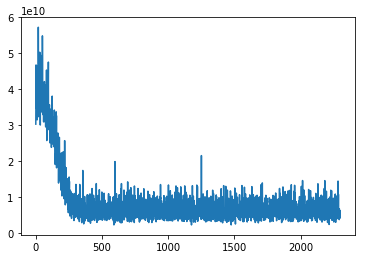

In [291]:
plt.plot(losses)

In [294]:
preds = model(t_train_cont, t_train_cat)

# for pred in preds:
#     pred = pred.sum()

# Rescale the predictions and the target variable
pd.concat([pd.DataFrame(preds.detach().data*y_std+y_mean, columns=['preds']), df_y], axis=1)
# pd.concat([pd.DataFrame(preds.detach().data, columns=['preds']), df_y], axis=1)

,preds,SalePrice
0,"tensor(1.4401259520e+10, device='cuda:0')",208500
1,"tensor(1.4401253376e+10, device='cuda:0')",181500
2,"tensor(1.4401258496e+10, device='cuda:0')",223500
3,"tensor(1.4401257472e+10, device='cuda:0')",140000
4,"tensor(1.4401255424e+10, device='cuda:0')",250000
5,"tensor(1.4401255424e+10, device='cuda:0')",143000
6,"tensor(1.4401255424e+10, device='cuda:0')",307000
7,"tensor(1.4401258496e+10, device='cuda:0')",200000
8,"tensor(1.4401255424e+10, device='cuda:0')",129900
9,"tensor(1.4401255424e+10, device='cuda:0')",118000


In [288]:
# model = TabularNet(emb_dims=emb_dims, num_cont=num_cont, lin_layer_sizes=[50, 100],
#                    output_size=1, emb_dropout=0.04, lin_layer_dropouts=[0.001, 0.01]).to(device)
model = TabularNet(emb_dims=emb_dims, num_cont=num_cont, lin_layer_sizes=[50, 100],
                   output_size=1, emb_dropout=0, lin_layer_dropouts=[0, 0]).to(device)

In [289]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)